<h2> <span style="color: Red;"> Amr Rashad | Neural Network Project | Cats & Dogs Dataset | 5-Fold CV </span> </h2>

## <span style="color: LightBlue;"> 0. Outline </span>

1. Setup & Load Data
    - Load required libraries
    - Setting up the directory
    - Loading and exploring the dataset
2. The deep learning model
    - Build the model
    - Splitting the data
    - Fitting the model
    - Training the model and visualizing average scores
    - Plotting model's preformance
3. Evaluating model's performance
    - Evaluate the model
        - Best Model Fold 1
        - Best Model Fold 2
        - Best Model Fold 3
        - Best Model Fold 4
        - Best Model Fold 5
        - Average Scores

## <span style="color: IndianRed;"> 1. Setup & Load Data </span>

### <span style="color: LightSalmon;"> *1.1 Load Required Libraries:* </span>

In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import cv2
import imghdr
import numpy as np
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import ReduceLROnPlateau
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from keras.callbacks import ModelCheckpoint
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Resizing
import numpy as np
import splitfolders
import seaborn as sns
from keras.metrics import Precision, Recall, BinaryAccuracy

### <span style="color: LightSalmon;"> *1.2 Setting Up The Directory:* </span>

In [2]:
data_dir = 'CatsDogs_ds'

In [3]:
os.listdir(data_dir)

['Cats', 'Dogs']

In [4]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
# Removing corrupted and broken images
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip!= 'jpeg':
                print('image does not have 3 channels {}'.format(image_path))
                os.remove(image_path)
            if tip not in image_exts:
                print('image is not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [ ]:
splitfolders.ratio(data_dir, output='CatsDogs_Split', seed= 1234, ratio = (0.8, 0.2))

In [5]:
Train_dir = 'CatsDogs_Split/train'
Test_dir = 'CatsDogs_Split/test'

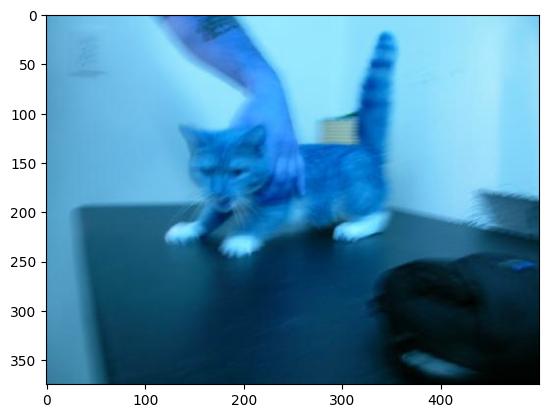

In [6]:
#Visualizing an image
img = cv2.imread(os.path.join('CatsDogs_Split/train','Cats', '0.jpg'))
plt.imshow(img)
plt.show()

### <span style="color: LightSalmon;"> *1.3 Loading & Exploring The Dataset:* </span>

In [7]:
#Building an image dataset on the fly, no need to build the labels, the classes. 
#Note: this will resize the images to 64x64.
#Images will be shuffled as well.
data = tf.keras.utils.image_dataset_from_directory('CatsDogs_Split/train', image_size=(64,64))

Found 19785 files belonging to 2 classes.


In [8]:
#This will allow us to access the generator from our data pipeline
data_iterator = data.as_numpy_iterator()

In [9]:
#Get another batch from the iterator
batch = data_iterator.next()

In [10]:
len(batch)

2

- There are 2 parts of the dataset:
    - The actual dataset images stored as numpy arrays
    - labels

In [11]:
batch[0].shape

(32, 64, 64, 3)

- Batch size is 32, image size is 256 by 256 by 3 channels

In [12]:
batch[1]

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1])

- Labels are either 0 or 1, meaning Cat or Dog.

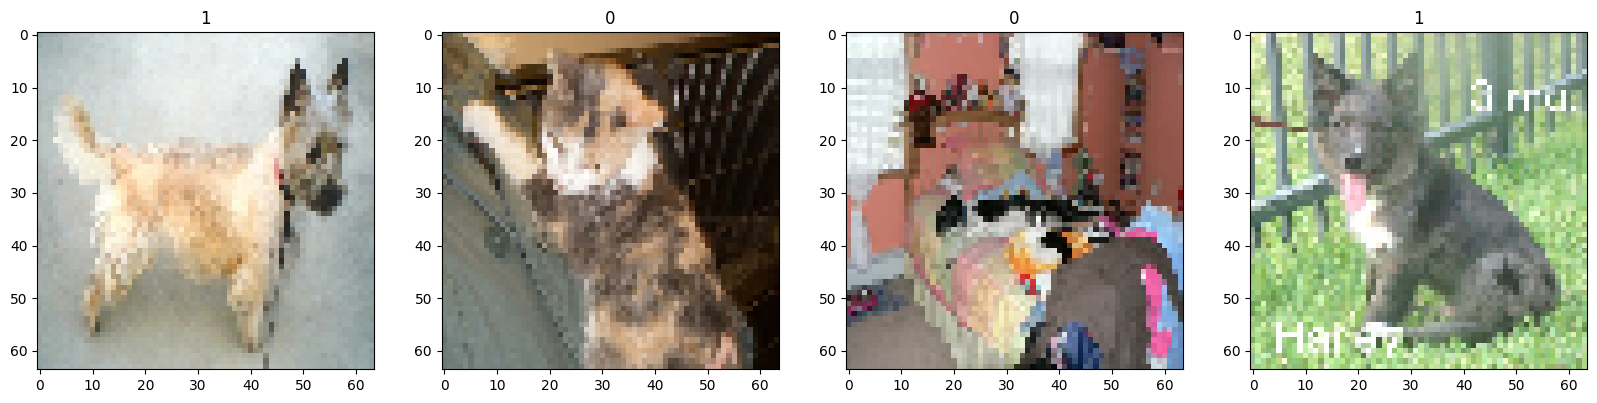

In [13]:
#Plotting the images to determine which value means Cat and which value means Dog
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

- From the above plot, we can determine that label 1 means dog and label 0 means cat.

## <span style="color: IndianRed;"> 2. The Deep Learning Model </span>

### <span style="color: LightSalmon;"> *2.1 Building The Model:* </span>

In [35]:
def cnn_model():    
    model = Sequential()
    #Resizing the images
    model.add(Resizing(100,100))
    #Scaling the image values between 0 & 1 instead of 0 to 255. This will help our Deep learning model to optimize faster and produce better results.
    model.add(Rescaling(1./255))
    #Data Augmentation to prevent overfitting
    model.add(RandomFlip('horizontal'))
    model.add(RandomRotation(0.2))
    model.add(RandomZoom(0.2))
    
    #Adding a convolutional layer and a MaxPooling layer
    #Each filter is going to be 3x3 in size and we are moving by 1 step/stride each time
    #Activation is going to be Rectified Linear Unit(relu), meaning any output below zero is going to be equal 0 and any other positive value is going to be preserved
    #MaxPooling helps us condense the information we get after the activation with the aim of getting the maximum values
    #MaxPooling halves the output of the Convolutional layer

    #First Layer
    model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    #Second Layer
    model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    #Third Layer
    model.add(Conv2D(128, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    #Fourth Layer
    model.add(Conv2D(256, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Dropout(0.2))

    #We have condensed the rows and the width and the number of filters will form the channel value
    #Now the aim when flattening the data is condense the channel value to a single value
    model.add(Flatten())

    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    #Now we are condensing them even more to get the final value (0 or 1 --> cat or dog)
    model.add(Dense(1, activation = 'sigmoid'))

    #List of optimizers can be checked --> (tf.optimizers.)
    model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

    return model

### <span style="color: LightSalmon;"> *2.2 Splitting The Data:* </span>

In [ ]:
n_folds = 5
for i in range(n_folds):
    splitfolders.ratio(Train_dir, output='Fold_'+str(i+1), seed= np.random.randint(1,1000,1)[0], ratio = (0.8, 0.2))

In [ ]:
n_folds = 5

### <span style="color: LightSalmon;"> *2.3 Fitting The Model:* </span>

In [50]:
#creating two empty arrays that will contain the loss and accuracy scores & a directory where best models of each iteration will be saved.
cv_accuracy_scores = []
cv_loss_scores = []
models_dir = 'saved_models'

In [51]:
def get_model_name(k):
    return '/model_'+str(k)+'.h5'

In [54]:
def fit_model(tr, val, iterator):
    model = None
    model = cnn_model()

    #define the model checkpoint callback -> this will keep on saving the model as a physical file
    model_checkpoint = ModelCheckpoint(models_dir+get_model_name(iterator), verbose=1, monitor='val_accuracy', mode=max, save_best_only=True)

    call_backs_list = [model_checkpoint]

    #fitting the model
    hist = model.fit(tr, validation_data = val, epochs=60, verbose = 1, callbacks = [call_backs_list, ReduceLROnPlateau()])
    
    #Evaluating the model
    best_model = load_model('saved_models/model_'+str(iterator)+'.h5')
    scores = best_model.evaluate(val, verbose = 0)
    cv_loss_scores.append(scores[0])
    cv_accuracy_scores.append(scores[1])
    iterator = iterator+1

    return hist

### <span style="color: LightSalmon;"> *2.4 Training The Model & Visualizing Average Scores:* </span>

In [55]:
model_hist = []
for i in range(n_folds):
    train_data = tf.keras.utils.image_dataset_from_directory('Fold_'+str(i+1)+'/train', image_size = (100,100))
    val_data = tf.keras.utils.image_dataset_from_directory('Fold_'+str(i+1)+'/val', image_size = (100,100))
    print("Training On Fold: ", i+1)
    model_hist.append(fit_model(train_data, val_data, (i+1)))
    print("======="*10, end="\n\n\n")

Found 15827 files belonging to 2 classes.
Found 3958 files belonging to 2 classes.
Training On Fold:  1
Epoch 1/60
495/495 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.5295
Epoch 1: val_accuracy improved from -inf to 0.57377, saving model to saved_models\model_1.h5
495/495 [==============================] - 271s 537ms/step - loss: 0.6879 - accuracy: 0.5295 - val_loss: 0.6825 - val_accuracy: 0.5738 - lr: 0.0010
Epoch 2/60
495/495 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.5762
Epoch 2: val_accuracy did not improve from 0.57377
495/495 [==============================] - 286s 578ms/step - loss: 0.6779 - accuracy: 0.5762 - val_loss: 0.6815 - val_accuracy: 0.5424 - lr: 0.0010
Epoch 3/60
495/495 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.6168
Epoch 3: val_accuracy improved from 0.57377 to 0.59626, saving model to saved_models\model_1.h5
495/495 [==============================] - 285s 575ms/step - loss: 0.652

In [58]:
print('average loss', np.mean(cv_loss_scores))
print('average accuracy', np.mean(cv_accuracy_scores))

average loss 0.27686133682727815
average accuracy 0.8873673439025879


### <span style="color: LightSalmon;"> *2.5 Plotting Model's Performance:* </span>

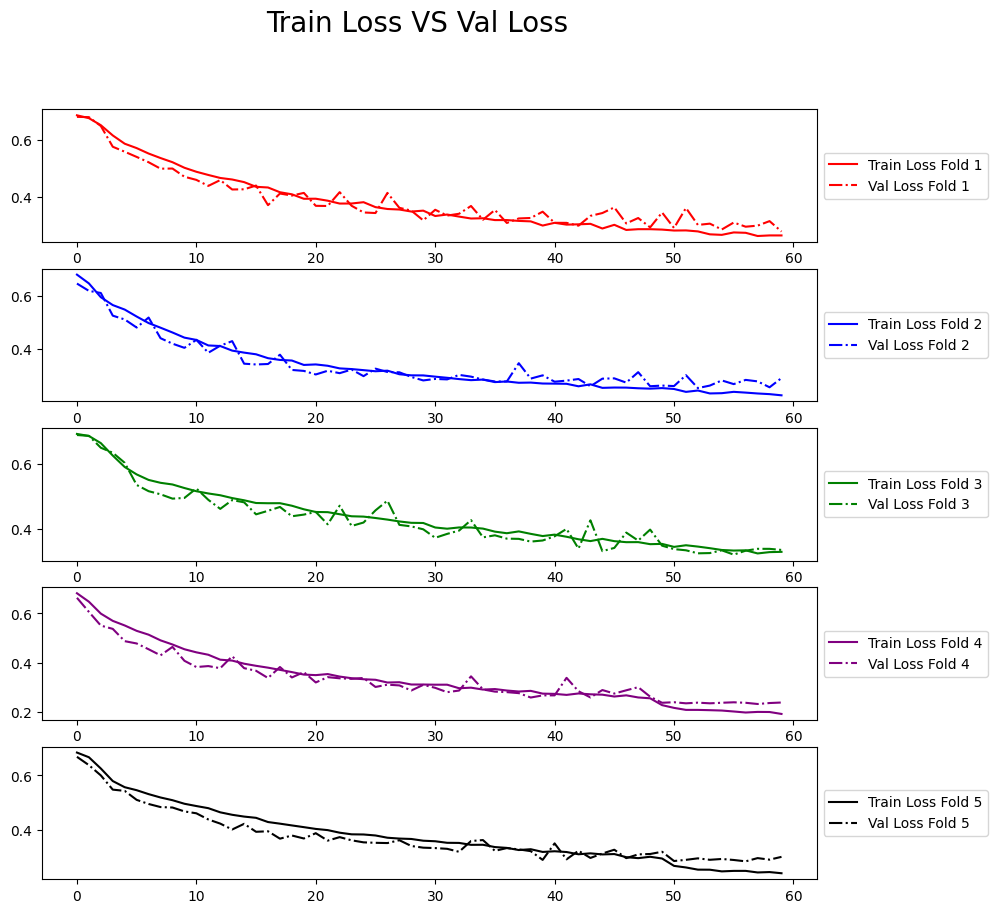

In [56]:
fig, axs = plt.subplots(5)
fig.set_figheight(10)
fig.set_figwidth(10)

axs[0].plot(model_hist[0].history['loss'], color = 'red', label = 'Train Loss Fold 1')
axs[0].plot(model_hist[0].history['val_loss'], color = 'red', label = 'Val Loss Fold 1', linestyle = 'dashdot')
axs[1].plot(model_hist[1].history['loss'], color = 'blue', label = 'Train Loss Fold 2')
axs[1].plot(model_hist[1].history['val_loss'], color = 'blue', label = 'Val Loss Fold 2', linestyle = 'dashdot')
axs[2].plot(model_hist[2].history['loss'], color = 'green', label = 'Train Loss Fold 3')
axs[2].plot(model_hist[2].history['val_loss'], color = 'green', label = 'Val Loss Fold 3', linestyle = 'dashdot')
axs[3].plot(model_hist[3].history['loss'], color = 'purple', label = 'Train Loss Fold 4')
axs[3].plot(model_hist[3].history['val_loss'], color = 'purple', label = 'Val Loss Fold 4', linestyle = 'dashdot')
axs[4].plot(model_hist[4].history['loss'], color = 'black', label = 'Train Loss Fold 5')
axs[4].plot(model_hist[4].history['val_loss'], color = 'black', label = 'Val Loss Fold 5', linestyle = 'dashdot')

axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))


fig.suptitle('Train Loss VS Val Loss', fontsize = 20)
plt.show()

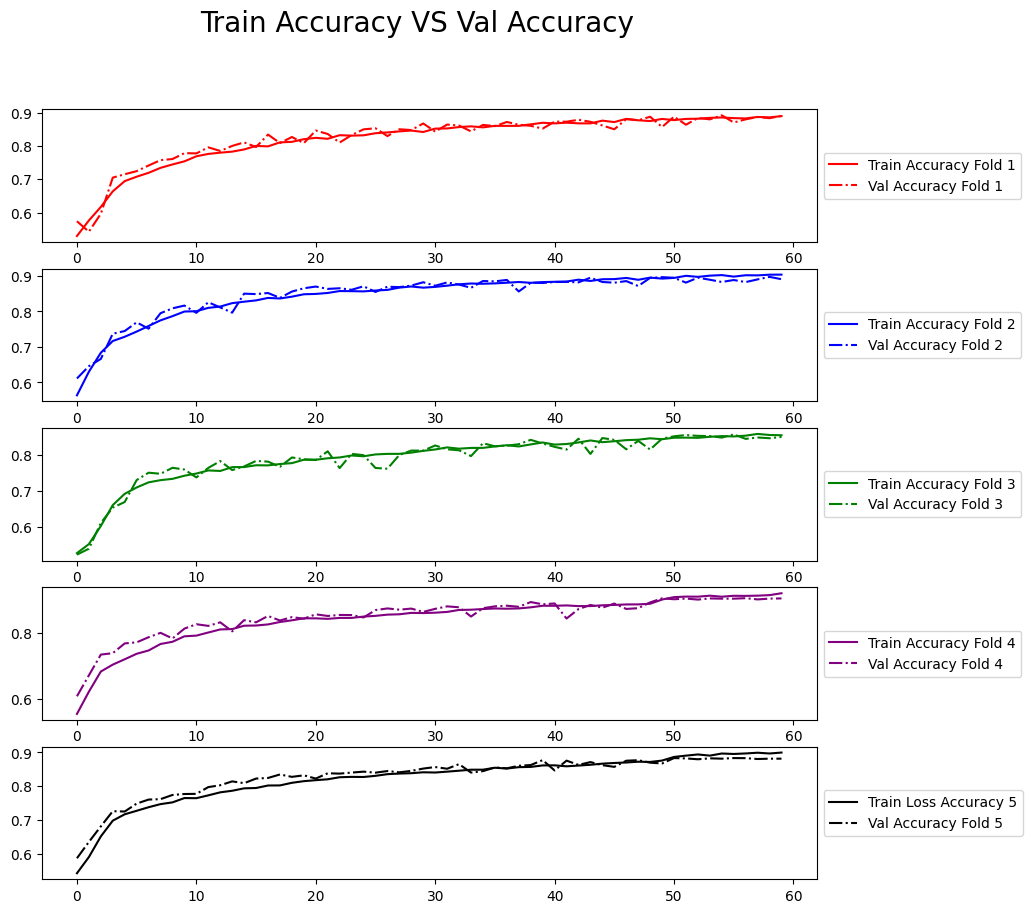

In [57]:
fig, axs = plt.subplots(5)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0].plot(model_hist[0].history['accuracy'], color = 'red', label = 'Train Accuracy Fold 1')
axs[0].plot(model_hist[0].history['val_accuracy'], color = 'red', label = 'Val Accuracy Fold 1', linestyle = 'dashdot')
axs[1].plot(model_hist[1].history['accuracy'], color = 'blue', label = 'Train Accuracy Fold 2')
axs[1].plot(model_hist[1].history['val_accuracy'], color = 'blue', label = 'Val Accuracy Fold 2', linestyle = 'dashdot')
axs[2].plot(model_hist[2].history['accuracy'], color = 'green', label = 'Train Accuracy Fold 3')
axs[2].plot(model_hist[2].history['val_accuracy'], color = 'green', label = 'Val Accuracy Fold 3', linestyle = 'dashdot')
axs[3].plot(model_hist[3].history['accuracy'], color = 'purple', label = 'Train Accuracy Fold 4')
axs[3].plot(model_hist[3].history['val_accuracy'], color = 'purple', label = 'Val Accuracy Fold 4', linestyle = 'dashdot')
axs[4].plot(model_hist[4].history['accuracy'], color = 'black', label = 'Train Loss Accuracy 5')
axs[4].plot(model_hist[4].history['val_accuracy'], color = 'black', label = 'Val Accuracy Fold 5', linestyle = 'dashdot')

axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle('Train Accuracy VS Val Accuracy', fontsize = 20)

plt.show()

## <span style="color: IndianRed;"> 3. Evaluating Model's Performance </span>

### <span style="color: LightSalmon;"> *3.1 Evaluate The Models:* </span>

In [6]:
test = tf.keras.utils.image_dataset_from_directory('CatsDogs_Split/test', image_size=(100,100))

Found 4947 files belonging to 2 classes.


In [25]:
Model_Precision = []
Model_Recall = []
Model_Accuracy = []

In [8]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

#### <span style="color: LightSalmon;"> *3.1.1 Best Model Fold 1:* </span>

In [11]:
best_model_f1 = load_model('saved_models/model_'+str(1)+'.h5')

In [60]:
#Visualizing model's summary:
best_model_f1.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_16 (Resizing)      (None, 100, 100, 3)       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 random_flip_16 (RandomFlip)  (None, 100, 100, 3)      0         
                                                                 
 random_rotation_16 (RandomR  (None, 100, 100, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_16 (RandomZoom)  (None, 100, 100, 3)      0         
                                                                 
 conv2d_58 (Conv2D)          (None, 98, 98, 32)        896       
                                                     

In [26]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = best_model_f1.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 49ms/step


In [27]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.8738595843315125, Recall:0.8919028043746948, Accuracy:0.8817465305328369


In [28]:
Model_Precision.append(pre.result().numpy())
Model_Recall.append(re.result().numpy())
Model_Accuracy.append(acc.result().numpy())

#### <span style="color: LightSalmon;"> *3.1.2 Best Model Fold 2:* </span>

In [29]:
best_model_f2 = load_model('saved_models/model_'+str(2)+'.h5')

In [30]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = best_model_f2.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 146ms/step


In [31]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.8775834441184998, Recall:0.8939270973205566, Accuracy:0.8847786784172058


In [32]:
Model_Precision.append(pre.result().numpy())
Model_Recall.append(re.result().numpy())
Model_Accuracy.append(acc.result().numpy())

#### <span style="color: LightSalmon;"> *3.1.3 Best Model Fold 3:* </span>

In [33]:
best_model_f3 = load_model('saved_models/model_'+str(3)+'.h5')

In [34]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = best_model_f3.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 173ms/step


In [35]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.8714653253555298, Recall:0.8921052813529968, Accuracy:0.8804326057434082


In [36]:
Model_Precision.append(pre.result().numpy())
Model_Recall.append(re.result().numpy())
Model_Accuracy.append(acc.result().numpy())

#### <span style="color: LightSalmon;"> *3.1.4 Best Model Fold 4:* </span>

In [37]:
best_model_f4 = load_model('saved_models/model_'+str(4)+'.h5')

In [38]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = best_model_f4.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 141ms/step


In [39]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.8751413822174072, Recall:0.8950838446617126, Accuracy:0.8838545680046082


In [40]:
Model_Precision.append(pre.result().numpy())
Model_Recall.append(re.result().numpy())
Model_Accuracy.append(acc.result().numpy())

#### <span style="color: LightSalmon;"> *3.1.5 Best Model Fold 5:* </span>

In [41]:
best_model_f5 = load_model('saved_models/model_'+str(5)+'.h5')

In [43]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = best_model_f5.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 139ms/step


In [44]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.8754870891571045, Recall:0.8995501399040222, Accuracy:0.8859690427780151


In [45]:
Model_Precision.append(pre.result().numpy())
Model_Recall.append(re.result().numpy())
Model_Accuracy.append(acc.result().numpy())

#### <span style="color: LightSalmon;"> *3.1.6 Average Scores:* </span>

In [49]:
print('average precision', np.mean(Model_Precision))
print('average recall', np.mean(Model_Recall))
print('average accuracy', np.mean(Model_Accuracy))

average precision 0.8747074
average recall 0.8945138
average accuracy 0.8833563
